# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

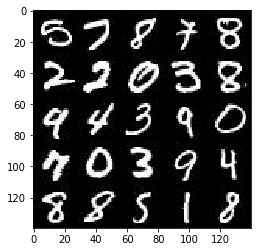

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

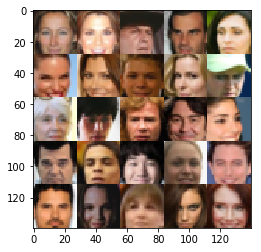

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Create placeholders for input data
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    
    # Create placeholders for hyperparameters
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return (real_input, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
# Define Leaky ReLU activation function used in convolutions
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x, alpha * x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # Reuse variables
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # Images have dimensions 28x28x<out_channel_dim>
        # * Run images through convolutional filters
        # * Use batch normalization in layers (except the first!) for better numerical properties
        # * Activation functions:
        # * - No activation in the initial "fully connected" layer
        # * - Leaky ReLU in conv layers
        # * - Sigmoid in output layer (to classify real/fake)
        
        # Discriminator hyperparams
        alpha = 0.1 # Leaky ReLU slope
        kernel_size = 3 # Same in all dims
        stride_size = 2 # Same in all dims

        ### Convolutions
        # 28x28x3 => 14x14x64
        conv1 = tf.layers.conv2d(images, 64, kernel_size, strides=stride_size, padding="same",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = leaky_relu(conv1, alpha)
        
        # 14x14x64 => 7x7x128
        conv2 = tf.layers.conv2d(conv1, 128, kernel_size, strides=stride_size, padding="same",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_relu(conv2, alpha)
        
        # 7x7x128 => 4x4x256
        conv3 = tf.layers.conv2d(conv2, 256, kernel_size, strides=stride_size, padding="same",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_relu(conv3, alpha)

        # Flatten: 4x4x256 => 4096
        flattened = tf.reshape(conv3, (-1, 4*4*256))

        # Classify if the image is real or fake 
        # 4096 => 1
        logits = tf.layers.dense(flattened, 1, activation=None,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    # Reuse variables
    with tf.variable_scope("generator", reuse=not is_train):
        
        # Images shall have dimensions 28x28x<out_channel_dim>
        # * Run images through transpose convolutional filters
        # * Use batch normalization in layers for better numerical properties
        # * Activation functions:
        # * - No activation in the initial "fully connected" layer
        # * - Leaky ReLU in transpose convolutional layers
        # * - tanh in output layer
 
        # Generator hyperparams
        alpha = 0.1 # Leaky ReLU slope
        kernel_size = 3 # Same in all dims
        stride_size = 2 # Same in all dims

        # Run z through a "fully connected" layer (really just a matrix multiplication)
        # Reshape fc output vector to a 4D tensor to be ready for convolutions
        # <z_dim> => 3072 => 3x3x512
        fc = tf.layers.dense(z, 3*3*512, activation=None)
        fc = tf.reshape(fc, (-1, 3, 3, 512))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        fc = leaky_relu(fc, alpha)
        
        # 3x3x512 => 7x7x256
        convT1 = tf.layers.conv2d_transpose(fc, 256, kernel_size, stride_size, "valid",
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        convT1 = tf.layers.batch_normalization(convT1, training=is_train)
        convT1 = leaky_relu(convT1, alpha)
        
        
        # 7x7x256 => 14x14x128
        convT2 = tf.layers.conv2d_transpose(convT1, 128, kernel_size, stride_size, "same",
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        convT2 = tf.layers.batch_normalization(convT2, training=is_train)
        convT2 = leaky_relu(convT2, alpha)


        # 14x14x128 => 28x28x<out_channel_dim>
        logits = tf.layers.conv2d_transpose(convT2, out_channel_dim, kernel_size, stride_size, "same",
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Apply label smoothing for real images
    # Gives better generalization
    label_smoothing = 0.9

    # Create generator
    g_out = generator(input_z, out_channel_dim, is_train=True)

    # Create discriminator
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)

    ### Calculate losses
    # Loss for REAL images (label = 1)
    # Use label smoothing 
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * label_smoothing))

    # Loss for FAKE images (label = 0)
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    # Generator loss
    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))


    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Separate trainable variables for the generator and discriminator
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

    
    # Create Adam optimizers for generator and discriminator separately
    # Typically adjust first momentum of Adam for stabilization
    # Make sure population statistics are correctly updated during training
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):    
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return (d_optimizer, g_optimizer) 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # Hyperparameters
    d_limit = 0.6
    g_limit = 0.5
    
    # Clarify some variable names
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    
    ### Build DCGAN
    # Create input placeholders
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)

    # Define losses
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)

    # Define optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    
    ### Train DCGAN 
    n_total_batches = data_shape[0] // batch_size
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                batch_counter += 1
                
                # Real images have values [-0.5, 0.5] after preprocessing
                # Generator images however have values [-1, 1] (tanh activation)
                # Thus, scale real image values to [-1, 1] as well
                batch_images = batch_images*2.0

                # Sample random noise to feed the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Try out training balancing scheme, hinted at in https://github.com/soumith/ganhacks/
                # Slightly more expensive, but not too bad
                training_loss_d = sess.run(d_loss, feed_dict={real_input: batch_images, 
                                                              z_input: batch_z})

                training_loss_g = sess.run(g_loss, feed_dict={z_input: batch_z})

                # Run optimizers
                while (training_loss_d > d_limit):
                    _ = sess.run(d_opt, feed_dict={real_input: batch_images, 
                                                   z_input: batch_z,
                                                   lr: learning_rate})
                
                    training_loss_d = sess.run(d_loss, feed_dict={real_input: batch_images, 
                                                                  z_input: batch_z})

                while (training_loss_g > g_limit):
                    _ = sess.run(g_opt, feed_dict={real_input: batch_images,
                                                   z_input: batch_z,
                                                   lr: learning_rate})

                    training_loss_g = sess.run(g_loss, feed_dict={z_input: batch_z})


                # Monitor losses during training
                # Yes, training_loss_d has changed again after taking steps in the generator.
                # But skip re-evauluation, just check stability
                if batch_counter % 10 == 0:
                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, batch_counter, n_total_batches),
                          "Discriminator loss = {:.4f} ".format(training_loss_d),
                          "Generator loss = {:.4f}".format(training_loss_g))
                                        
                # Sample generator output every once in a while
                if batch_counter % 100 == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)

        # Sample at the end of training
        show_generator_output(sess, 25, z_input, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/937:  Discriminator loss = 0.4869  Generator loss = 0.1771
Epoch 1/2 - Batch 20/937:  Discriminator loss = 0.4299  Generator loss = 0.3553
Epoch 1/2 - Batch 30/937:  Discriminator loss = 0.5271  Generator loss = 0.4130
Epoch 1/2 - Batch 40/937:  Discriminator loss = 0.5490  Generator loss = 0.2651
Epoch 1/2 - Batch 50/937:  Discriminator loss = 0.4801  Generator loss = 0.4744
Epoch 1/2 - Batch 60/937:  Discriminator loss = 0.4456  Generator loss = 0.2465
Epoch 1/2 - Batch 70/937:  Discriminator loss = 0.4955  Generator loss = 0.4103
Epoch 1/2 - Batch 80/937:  Discriminator loss = 0.5073  Generator loss = 0.2407
Epoch 1/2 - Batch 90/937:  Discriminator loss = 0.4781  Generator loss = 0.2962
Epoch 1/2 - Batch 100/937:  Discriminator loss = 0.5579  Generator loss = 0.3388


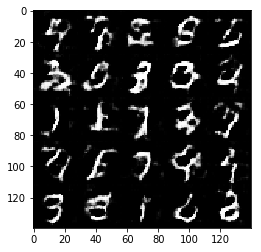

Epoch 1/2 - Batch 110/937:  Discriminator loss = 0.5944  Generator loss = 0.3859
Epoch 1/2 - Batch 120/937:  Discriminator loss = 0.5670  Generator loss = 0.3498
Epoch 1/2 - Batch 130/937:  Discriminator loss = 0.4517  Generator loss = 0.4765
Epoch 1/2 - Batch 140/937:  Discriminator loss = 0.5993  Generator loss = 0.3952
Epoch 1/2 - Batch 150/937:  Discriminator loss = 0.4678  Generator loss = 0.4140
Epoch 1/2 - Batch 160/937:  Discriminator loss = 0.5360  Generator loss = 0.2598
Epoch 1/2 - Batch 170/937:  Discriminator loss = 0.5804  Generator loss = 0.2710
Epoch 1/2 - Batch 180/937:  Discriminator loss = 0.5350  Generator loss = 0.3187
Epoch 1/2 - Batch 190/937:  Discriminator loss = 0.4604  Generator loss = 0.3728
Epoch 1/2 - Batch 200/937:  Discriminator loss = 0.5902  Generator loss = 0.3358


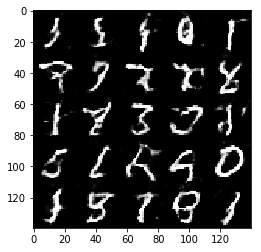

Epoch 1/2 - Batch 210/937:  Discriminator loss = 0.5212  Generator loss = 0.4731
Epoch 1/2 - Batch 220/937:  Discriminator loss = 0.5680  Generator loss = 0.2911
Epoch 1/2 - Batch 230/937:  Discriminator loss = 0.4938  Generator loss = 0.3975
Epoch 1/2 - Batch 240/937:  Discriminator loss = 0.4879  Generator loss = 0.3434
Epoch 1/2 - Batch 250/937:  Discriminator loss = 0.5028  Generator loss = 0.4015
Epoch 1/2 - Batch 260/937:  Discriminator loss = 0.4465  Generator loss = 0.2791
Epoch 1/2 - Batch 270/937:  Discriminator loss = 0.4819  Generator loss = 0.2753
Epoch 1/2 - Batch 280/937:  Discriminator loss = 0.5998  Generator loss = 0.4889
Epoch 1/2 - Batch 290/937:  Discriminator loss = 0.5452  Generator loss = 0.4862
Epoch 1/2 - Batch 300/937:  Discriminator loss = 0.4430  Generator loss = 0.3880


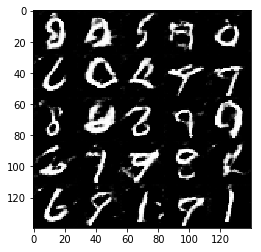

Epoch 1/2 - Batch 310/937:  Discriminator loss = 0.3917  Generator loss = 0.4322
Epoch 1/2 - Batch 320/937:  Discriminator loss = 0.5300  Generator loss = 0.2652
Epoch 1/2 - Batch 330/937:  Discriminator loss = 0.5133  Generator loss = 0.4291
Epoch 1/2 - Batch 340/937:  Discriminator loss = 0.5593  Generator loss = 0.4141
Epoch 1/2 - Batch 350/937:  Discriminator loss = 0.5171  Generator loss = 0.3772
Epoch 1/2 - Batch 360/937:  Discriminator loss = 0.4194  Generator loss = 0.3387
Epoch 1/2 - Batch 370/937:  Discriminator loss = 0.5766  Generator loss = 0.4900
Epoch 1/2 - Batch 380/937:  Discriminator loss = 0.5428  Generator loss = 0.3802
Epoch 1/2 - Batch 390/937:  Discriminator loss = 0.5318  Generator loss = 0.4747
Epoch 1/2 - Batch 400/937:  Discriminator loss = 0.4882  Generator loss = 0.4305


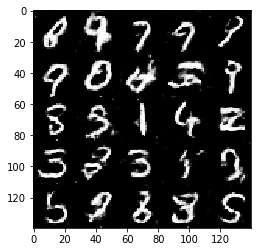

Epoch 1/2 - Batch 410/937:  Discriminator loss = 0.5667  Generator loss = 0.2742
Epoch 1/2 - Batch 420/937:  Discriminator loss = 0.4940  Generator loss = 0.2335
Epoch 1/2 - Batch 430/937:  Discriminator loss = 0.4902  Generator loss = 0.2583
Epoch 1/2 - Batch 440/937:  Discriminator loss = 0.5783  Generator loss = 0.4637
Epoch 1/2 - Batch 450/937:  Discriminator loss = 0.5448  Generator loss = 0.2765
Epoch 1/2 - Batch 460/937:  Discriminator loss = 0.5295  Generator loss = 0.4039
Epoch 1/2 - Batch 470/937:  Discriminator loss = 0.5148  Generator loss = 0.3535
Epoch 1/2 - Batch 480/937:  Discriminator loss = 0.4873  Generator loss = 0.2401
Epoch 1/2 - Batch 490/937:  Discriminator loss = 0.5499  Generator loss = 0.2661
Epoch 1/2 - Batch 500/937:  Discriminator loss = 0.5678  Generator loss = 0.3705


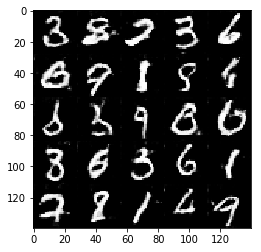

Epoch 1/2 - Batch 510/937:  Discriminator loss = 0.4962  Generator loss = 0.2792
Epoch 1/2 - Batch 520/937:  Discriminator loss = 0.5303  Generator loss = 0.2993
Epoch 1/2 - Batch 530/937:  Discriminator loss = 0.5858  Generator loss = 0.2713
Epoch 1/2 - Batch 540/937:  Discriminator loss = 0.4609  Generator loss = 0.4362
Epoch 1/2 - Batch 550/937:  Discriminator loss = 0.4960  Generator loss = 0.4960
Epoch 1/2 - Batch 560/937:  Discriminator loss = 0.5707  Generator loss = 0.3529
Epoch 1/2 - Batch 570/937:  Discriminator loss = 0.5396  Generator loss = 0.3396
Epoch 1/2 - Batch 580/937:  Discriminator loss = 0.5571  Generator loss = 0.3963
Epoch 1/2 - Batch 590/937:  Discriminator loss = 0.4371  Generator loss = 0.3575
Epoch 1/2 - Batch 600/937:  Discriminator loss = 0.4312  Generator loss = 0.3631


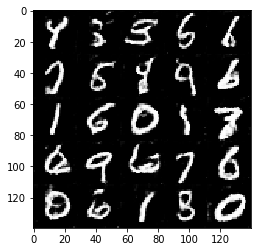

Epoch 1/2 - Batch 610/937:  Discriminator loss = 0.5703  Generator loss = 0.2842
Epoch 1/2 - Batch 620/937:  Discriminator loss = 0.5749  Generator loss = 0.2585
Epoch 1/2 - Batch 630/937:  Discriminator loss = 0.4466  Generator loss = 0.3583
Epoch 1/2 - Batch 640/937:  Discriminator loss = 0.4844  Generator loss = 0.3713
Epoch 1/2 - Batch 650/937:  Discriminator loss = 0.4992  Generator loss = 0.4691
Epoch 1/2 - Batch 660/937:  Discriminator loss = 0.4058  Generator loss = 0.2472
Epoch 1/2 - Batch 670/937:  Discriminator loss = 0.4620  Generator loss = 0.3124
Epoch 1/2 - Batch 680/937:  Discriminator loss = 0.5261  Generator loss = 0.4501
Epoch 1/2 - Batch 690/937:  Discriminator loss = 0.4707  Generator loss = 0.3347
Epoch 1/2 - Batch 700/937:  Discriminator loss = 0.5527  Generator loss = 0.3736


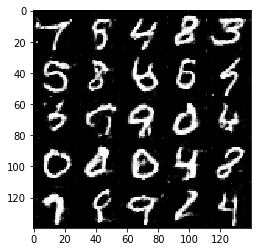

Epoch 1/2 - Batch 710/937:  Discriminator loss = 0.5752  Generator loss = 0.2375
Epoch 1/2 - Batch 720/937:  Discriminator loss = 0.5551  Generator loss = 0.2334
Epoch 1/2 - Batch 730/937:  Discriminator loss = 0.4667  Generator loss = 0.3009
Epoch 1/2 - Batch 740/937:  Discriminator loss = 0.5333  Generator loss = 0.3189
Epoch 1/2 - Batch 750/937:  Discriminator loss = 0.4659  Generator loss = 0.2953
Epoch 1/2 - Batch 760/937:  Discriminator loss = 0.5608  Generator loss = 0.2108
Epoch 1/2 - Batch 770/937:  Discriminator loss = 0.5232  Generator loss = 0.2885
Epoch 1/2 - Batch 780/937:  Discriminator loss = 0.5643  Generator loss = 0.2693
Epoch 1/2 - Batch 790/937:  Discriminator loss = 0.5208  Generator loss = 0.2067
Epoch 1/2 - Batch 800/937:  Discriminator loss = 0.5241  Generator loss = 0.2848


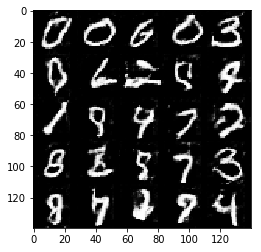

Epoch 1/2 - Batch 810/937:  Discriminator loss = 0.5993  Generator loss = 0.4031
Epoch 1/2 - Batch 820/937:  Discriminator loss = 0.4903  Generator loss = 0.4879
Epoch 1/2 - Batch 830/937:  Discriminator loss = 0.4043  Generator loss = 0.3117
Epoch 1/2 - Batch 840/937:  Discriminator loss = 0.4290  Generator loss = 0.3100
Epoch 1/2 - Batch 850/937:  Discriminator loss = 0.5823  Generator loss = 0.3680
Epoch 1/2 - Batch 860/937:  Discriminator loss = 0.5373  Generator loss = 0.4637
Epoch 1/2 - Batch 870/937:  Discriminator loss = 0.5663  Generator loss = 0.4926
Epoch 1/2 - Batch 880/937:  Discriminator loss = 0.5178  Generator loss = 0.1984
Epoch 1/2 - Batch 890/937:  Discriminator loss = 0.5085  Generator loss = 0.4373
Epoch 1/2 - Batch 900/937:  Discriminator loss = 0.5165  Generator loss = 0.2152


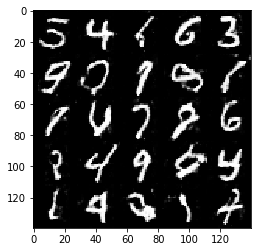

Epoch 1/2 - Batch 910/937:  Discriminator loss = 0.4901  Generator loss = 0.3679
Epoch 1/2 - Batch 920/937:  Discriminator loss = 0.5315  Generator loss = 0.3710
Epoch 1/2 - Batch 930/937:  Discriminator loss = 0.4924  Generator loss = 0.2234
Epoch 2/2 - Batch 10/937:  Discriminator loss = 0.5573  Generator loss = 0.2269
Epoch 2/2 - Batch 20/937:  Discriminator loss = 0.5276  Generator loss = 0.2934
Epoch 2/2 - Batch 30/937:  Discriminator loss = 0.5551  Generator loss = 0.4904
Epoch 2/2 - Batch 40/937:  Discriminator loss = 0.5663  Generator loss = 0.2462
Epoch 2/2 - Batch 50/937:  Discriminator loss = 0.4440  Generator loss = 0.2306
Epoch 2/2 - Batch 60/937:  Discriminator loss = 0.5085  Generator loss = 0.2743
Epoch 2/2 - Batch 70/937:  Discriminator loss = 0.5862  Generator loss = 0.4623
Epoch 2/2 - Batch 80/937:  Discriminator loss = 0.5316  Generator loss = 0.3141
Epoch 2/2 - Batch 90/937:  Discriminator loss = 0.4583  Generator loss = 0.2991
Epoch 2/2 - Batch 100/937:  Discrimin

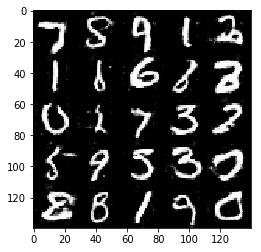

Epoch 2/2 - Batch 110/937:  Discriminator loss = 0.5410  Generator loss = 0.4812
Epoch 2/2 - Batch 120/937:  Discriminator loss = 0.5932  Generator loss = 0.4266
Epoch 2/2 - Batch 130/937:  Discriminator loss = 0.4324  Generator loss = 0.2657
Epoch 2/2 - Batch 140/937:  Discriminator loss = 0.5309  Generator loss = 0.1805
Epoch 2/2 - Batch 150/937:  Discriminator loss = 0.5301  Generator loss = 0.2595
Epoch 2/2 - Batch 160/937:  Discriminator loss = 0.4545  Generator loss = 0.3957
Epoch 2/2 - Batch 170/937:  Discriminator loss = 0.5261  Generator loss = 0.3234
Epoch 2/2 - Batch 180/937:  Discriminator loss = 0.5320  Generator loss = 0.4747
Epoch 2/2 - Batch 190/937:  Discriminator loss = 0.5033  Generator loss = 0.3250
Epoch 2/2 - Batch 200/937:  Discriminator loss = 0.5414  Generator loss = 0.1870


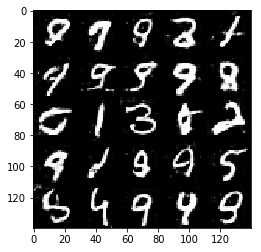

Epoch 2/2 - Batch 210/937:  Discriminator loss = 0.4704  Generator loss = 0.2134
Epoch 2/2 - Batch 220/937:  Discriminator loss = 0.5528  Generator loss = 0.3217
Epoch 2/2 - Batch 230/937:  Discriminator loss = 0.4653  Generator loss = 0.2263
Epoch 2/2 - Batch 240/937:  Discriminator loss = 0.5333  Generator loss = 0.1509
Epoch 2/2 - Batch 250/937:  Discriminator loss = 0.5356  Generator loss = 0.4584
Epoch 2/2 - Batch 260/937:  Discriminator loss = 0.4498  Generator loss = 0.4308
Epoch 2/2 - Batch 270/937:  Discriminator loss = 0.5025  Generator loss = 0.2038
Epoch 2/2 - Batch 280/937:  Discriminator loss = 0.4996  Generator loss = 0.3434
Epoch 2/2 - Batch 290/937:  Discriminator loss = 0.5578  Generator loss = 0.3704
Epoch 2/2 - Batch 300/937:  Discriminator loss = 0.5305  Generator loss = 0.2080


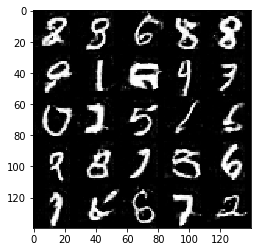

Epoch 2/2 - Batch 310/937:  Discriminator loss = 0.4510  Generator loss = 0.4364
Epoch 2/2 - Batch 320/937:  Discriminator loss = 0.5499  Generator loss = 0.3184
Epoch 2/2 - Batch 330/937:  Discriminator loss = 0.5292  Generator loss = 0.3948
Epoch 2/2 - Batch 340/937:  Discriminator loss = 0.5005  Generator loss = 0.2294
Epoch 2/2 - Batch 350/937:  Discriminator loss = 0.5210  Generator loss = 0.4195
Epoch 2/2 - Batch 360/937:  Discriminator loss = 0.5036  Generator loss = 0.3573
Epoch 2/2 - Batch 370/937:  Discriminator loss = 0.5547  Generator loss = 0.3862
Epoch 2/2 - Batch 380/937:  Discriminator loss = 0.4408  Generator loss = 0.3314
Epoch 2/2 - Batch 390/937:  Discriminator loss = 0.5984  Generator loss = 0.1635
Epoch 2/2 - Batch 400/937:  Discriminator loss = 0.4098  Generator loss = 0.2791


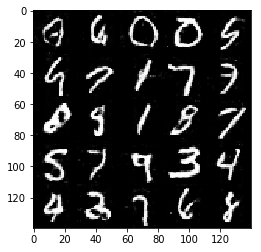

Epoch 2/2 - Batch 410/937:  Discriminator loss = 0.4439  Generator loss = 0.2932
Epoch 2/2 - Batch 420/937:  Discriminator loss = 0.4566  Generator loss = 0.4518
Epoch 2/2 - Batch 430/937:  Discriminator loss = 0.5064  Generator loss = 0.1498
Epoch 2/2 - Batch 440/937:  Discriminator loss = 0.5417  Generator loss = 0.4563
Epoch 2/2 - Batch 450/937:  Discriminator loss = 0.5779  Generator loss = 0.3749
Epoch 2/2 - Batch 460/937:  Discriminator loss = 0.4300  Generator loss = 0.3744
Epoch 2/2 - Batch 470/937:  Discriminator loss = 0.4817  Generator loss = 0.2537
Epoch 2/2 - Batch 480/937:  Discriminator loss = 0.4515  Generator loss = 0.3316
Epoch 2/2 - Batch 490/937:  Discriminator loss = 0.5248  Generator loss = 0.3440
Epoch 2/2 - Batch 500/937:  Discriminator loss = 0.4793  Generator loss = 0.3773


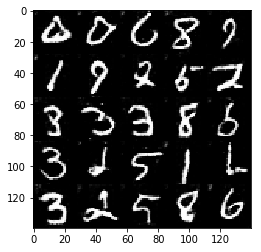

Epoch 2/2 - Batch 510/937:  Discriminator loss = 0.5299  Generator loss = 0.3696
Epoch 2/2 - Batch 520/937:  Discriminator loss = 0.4061  Generator loss = 0.3129
Epoch 2/2 - Batch 530/937:  Discriminator loss = 0.5843  Generator loss = 0.4040
Epoch 2/2 - Batch 540/937:  Discriminator loss = 0.4459  Generator loss = 0.2722
Epoch 2/2 - Batch 550/937:  Discriminator loss = 0.5434  Generator loss = 0.2464
Epoch 2/2 - Batch 560/937:  Discriminator loss = 0.3770  Generator loss = 0.4044
Epoch 2/2 - Batch 570/937:  Discriminator loss = 0.5418  Generator loss = 0.2565
Epoch 2/2 - Batch 580/937:  Discriminator loss = 0.4826  Generator loss = 0.2883
Epoch 2/2 - Batch 590/937:  Discriminator loss = 0.5115  Generator loss = 0.2462
Epoch 2/2 - Batch 600/937:  Discriminator loss = 0.3723  Generator loss = 0.4521


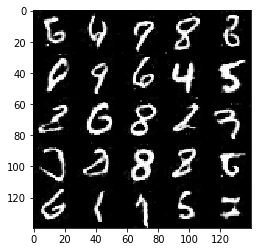

Epoch 2/2 - Batch 610/937:  Discriminator loss = 0.4717  Generator loss = 0.4056
Epoch 2/2 - Batch 620/937:  Discriminator loss = 0.5650  Generator loss = 0.1690
Epoch 2/2 - Batch 630/937:  Discriminator loss = 0.4243  Generator loss = 0.3897
Epoch 2/2 - Batch 640/937:  Discriminator loss = 0.4192  Generator loss = 0.2966
Epoch 2/2 - Batch 650/937:  Discriminator loss = 0.4800  Generator loss = 0.1395
Epoch 2/2 - Batch 660/937:  Discriminator loss = 0.5577  Generator loss = 0.4031
Epoch 2/2 - Batch 670/937:  Discriminator loss = 0.5052  Generator loss = 0.4451
Epoch 2/2 - Batch 680/937:  Discriminator loss = 0.4815  Generator loss = 0.4856
Epoch 2/2 - Batch 690/937:  Discriminator loss = 0.4607  Generator loss = 0.3667
Epoch 2/2 - Batch 700/937:  Discriminator loss = 0.5639  Generator loss = 0.4512


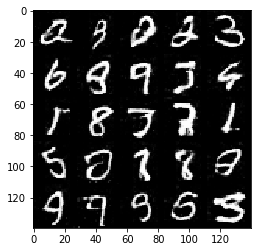

Epoch 2/2 - Batch 710/937:  Discriminator loss = 0.4025  Generator loss = 0.3098
Epoch 2/2 - Batch 720/937:  Discriminator loss = 0.4378  Generator loss = 0.3210
Epoch 2/2 - Batch 730/937:  Discriminator loss = 0.4770  Generator loss = 0.2997
Epoch 2/2 - Batch 740/937:  Discriminator loss = 0.3830  Generator loss = 0.4793
Epoch 2/2 - Batch 750/937:  Discriminator loss = 0.4663  Generator loss = 0.1618
Epoch 2/2 - Batch 760/937:  Discriminator loss = 0.5369  Generator loss = 0.4829
Epoch 2/2 - Batch 770/937:  Discriminator loss = 0.5898  Generator loss = 0.1833
Epoch 2/2 - Batch 780/937:  Discriminator loss = 0.4464  Generator loss = 0.2530
Epoch 2/2 - Batch 790/937:  Discriminator loss = 0.5398  Generator loss = 0.3962
Epoch 2/2 - Batch 800/937:  Discriminator loss = 0.5766  Generator loss = 0.3528


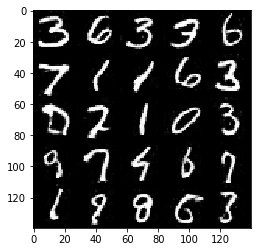

Epoch 2/2 - Batch 810/937:  Discriminator loss = 0.5998  Generator loss = 0.4700
Epoch 2/2 - Batch 820/937:  Discriminator loss = 0.3973  Generator loss = 0.3950
Epoch 2/2 - Batch 830/937:  Discriminator loss = 0.5142  Generator loss = 0.2122
Epoch 2/2 - Batch 840/937:  Discriminator loss = 0.5917  Generator loss = 0.2166
Epoch 2/2 - Batch 850/937:  Discriminator loss = 0.4745  Generator loss = 0.2551
Epoch 2/2 - Batch 860/937:  Discriminator loss = 0.3986  Generator loss = 0.3863
Epoch 2/2 - Batch 870/937:  Discriminator loss = 0.4765  Generator loss = 0.3901
Epoch 2/2 - Batch 880/937:  Discriminator loss = 0.5742  Generator loss = 0.1897
Epoch 2/2 - Batch 890/937:  Discriminator loss = 0.4177  Generator loss = 0.2301
Epoch 2/2 - Batch 900/937:  Discriminator loss = 0.5552  Generator loss = 0.1635


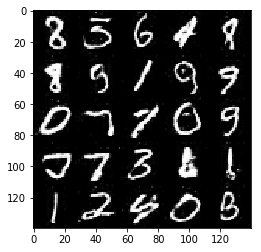

Epoch 2/2 - Batch 910/937:  Discriminator loss = 0.5845  Generator loss = 0.3745
Epoch 2/2 - Batch 920/937:  Discriminator loss = 0.4675  Generator loss = 0.2541
Epoch 2/2 - Batch 930/937:  Discriminator loss = 0.4447  Generator loss = 0.3612


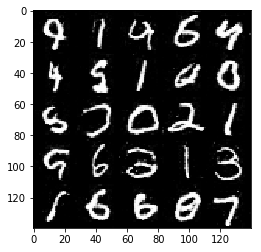

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2


mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/3165:  Discriminator loss = 0.5561  Generator loss = 0.4615
Epoch 1/1 - Batch 20/3165:  Discriminator loss = 0.5957  Generator loss = 0.4680
Epoch 1/1 - Batch 30/3165:  Discriminator loss = 0.5810  Generator loss = 0.2023
Epoch 1/1 - Batch 40/3165:  Discriminator loss = 0.5560  Generator loss = 0.2740
Epoch 1/1 - Batch 50/3165:  Discriminator loss = 0.5408  Generator loss = 0.2044
Epoch 1/1 - Batch 60/3165:  Discriminator loss = 0.5639  Generator loss = 0.3801
Epoch 1/1 - Batch 70/3165:  Discriminator loss = 0.5798  Generator loss = 0.4582
Epoch 1/1 - Batch 80/3165:  Discriminator loss = 0.5774  Generator loss = 0.3194
Epoch 1/1 - Batch 90/3165:  Discriminator loss = 0.5230  Generator loss = 0.1583
Epoch 1/1 - Batch 100/3165:  Discriminator loss = 0.5508  Generator loss = 0.2927


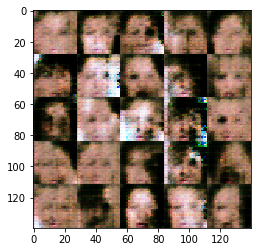

Epoch 1/1 - Batch 110/3165:  Discriminator loss = 0.5497  Generator loss = 0.3710
Epoch 1/1 - Batch 120/3165:  Discriminator loss = 0.5488  Generator loss = 0.4280
Epoch 1/1 - Batch 130/3165:  Discriminator loss = 0.5432  Generator loss = 0.3760
Epoch 1/1 - Batch 140/3165:  Discriminator loss = 0.5266  Generator loss = 0.4925
Epoch 1/1 - Batch 150/3165:  Discriminator loss = 0.5554  Generator loss = 0.1917
Epoch 1/1 - Batch 160/3165:  Discriminator loss = 0.5726  Generator loss = 0.3778
Epoch 1/1 - Batch 170/3165:  Discriminator loss = 0.4436  Generator loss = 0.3949
Epoch 1/1 - Batch 180/3165:  Discriminator loss = 0.5509  Generator loss = 0.3724
Epoch 1/1 - Batch 190/3165:  Discriminator loss = 0.5928  Generator loss = 0.4662
Epoch 1/1 - Batch 200/3165:  Discriminator loss = 0.5620  Generator loss = 0.3590


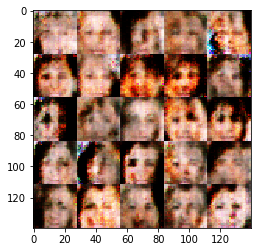

Epoch 1/1 - Batch 210/3165:  Discriminator loss = 0.5783  Generator loss = 0.4768
Epoch 1/1 - Batch 220/3165:  Discriminator loss = 0.5737  Generator loss = 0.3933
Epoch 1/1 - Batch 230/3165:  Discriminator loss = 0.4923  Generator loss = 0.2130
Epoch 1/1 - Batch 240/3165:  Discriminator loss = 0.5664  Generator loss = 0.3843
Epoch 1/1 - Batch 250/3165:  Discriminator loss = 0.5750  Generator loss = 0.2670
Epoch 1/1 - Batch 260/3165:  Discriminator loss = 0.5903  Generator loss = 0.3858
Epoch 1/1 - Batch 270/3165:  Discriminator loss = 0.5196  Generator loss = 0.3571
Epoch 1/1 - Batch 280/3165:  Discriminator loss = 0.5223  Generator loss = 0.2723
Epoch 1/1 - Batch 290/3165:  Discriminator loss = 0.4829  Generator loss = 0.2012
Epoch 1/1 - Batch 300/3165:  Discriminator loss = 0.5163  Generator loss = 0.3692


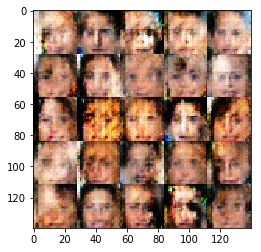

Epoch 1/1 - Batch 310/3165:  Discriminator loss = 0.4560  Generator loss = 0.3693
Epoch 1/1 - Batch 320/3165:  Discriminator loss = 0.5655  Generator loss = 0.3386
Epoch 1/1 - Batch 330/3165:  Discriminator loss = 0.4940  Generator loss = 0.3650
Epoch 1/1 - Batch 340/3165:  Discriminator loss = 0.4402  Generator loss = 0.3181
Epoch 1/1 - Batch 350/3165:  Discriminator loss = 0.5068  Generator loss = 0.3157
Epoch 1/1 - Batch 360/3165:  Discriminator loss = 0.5482  Generator loss = 0.3423
Epoch 1/1 - Batch 370/3165:  Discriminator loss = 0.5500  Generator loss = 0.3360
Epoch 1/1 - Batch 380/3165:  Discriminator loss = 0.5451  Generator loss = 0.4531
Epoch 1/1 - Batch 390/3165:  Discriminator loss = 0.5531  Generator loss = 0.4975
Epoch 1/1 - Batch 400/3165:  Discriminator loss = 0.5448  Generator loss = 0.4811


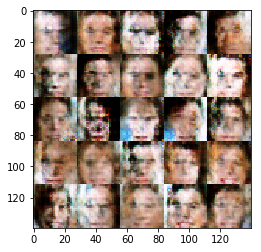

Epoch 1/1 - Batch 410/3165:  Discriminator loss = 0.5749  Generator loss = 0.4777
Epoch 1/1 - Batch 420/3165:  Discriminator loss = 0.5203  Generator loss = 0.2502
Epoch 1/1 - Batch 430/3165:  Discriminator loss = 0.5212  Generator loss = 0.4613
Epoch 1/1 - Batch 440/3165:  Discriminator loss = 0.5959  Generator loss = 0.4842
Epoch 1/1 - Batch 450/3165:  Discriminator loss = 0.5432  Generator loss = 0.3259
Epoch 1/1 - Batch 460/3165:  Discriminator loss = 0.5165  Generator loss = 0.3892
Epoch 1/1 - Batch 470/3165:  Discriminator loss = 0.5194  Generator loss = 0.2953
Epoch 1/1 - Batch 480/3165:  Discriminator loss = 0.5830  Generator loss = 0.3267
Epoch 1/1 - Batch 490/3165:  Discriminator loss = 0.5966  Generator loss = 0.4970
Epoch 1/1 - Batch 500/3165:  Discriminator loss = 0.5389  Generator loss = 0.2402


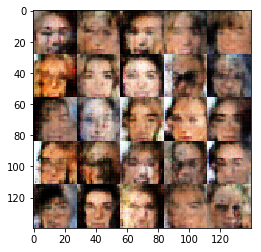

Epoch 1/1 - Batch 510/3165:  Discriminator loss = 0.5593  Generator loss = 0.3277
Epoch 1/1 - Batch 520/3165:  Discriminator loss = 0.5716  Generator loss = 0.2139
Epoch 1/1 - Batch 530/3165:  Discriminator loss = 0.5452  Generator loss = 0.2568
Epoch 1/1 - Batch 540/3165:  Discriminator loss = 0.5028  Generator loss = 0.2328
Epoch 1/1 - Batch 550/3165:  Discriminator loss = 0.5473  Generator loss = 0.4843
Epoch 1/1 - Batch 560/3165:  Discriminator loss = 0.5131  Generator loss = 0.4948
Epoch 1/1 - Batch 570/3165:  Discriminator loss = 0.5373  Generator loss = 0.2581
Epoch 1/1 - Batch 580/3165:  Discriminator loss = 0.5560  Generator loss = 0.2206
Epoch 1/1 - Batch 590/3165:  Discriminator loss = 0.5132  Generator loss = 0.2647
Epoch 1/1 - Batch 600/3165:  Discriminator loss = 0.5889  Generator loss = 0.2373


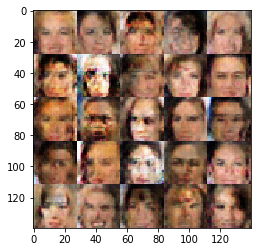

Epoch 1/1 - Batch 610/3165:  Discriminator loss = 0.5486  Generator loss = 0.3663
Epoch 1/1 - Batch 620/3165:  Discriminator loss = 0.5657  Generator loss = 0.4154
Epoch 1/1 - Batch 630/3165:  Discriminator loss = 0.5440  Generator loss = 0.4419
Epoch 1/1 - Batch 640/3165:  Discriminator loss = 0.5016  Generator loss = 0.4997
Epoch 1/1 - Batch 650/3165:  Discriminator loss = 0.5057  Generator loss = 0.4396
Epoch 1/1 - Batch 660/3165:  Discriminator loss = 0.5086  Generator loss = 0.2693
Epoch 1/1 - Batch 670/3165:  Discriminator loss = 0.5010  Generator loss = 0.1493
Epoch 1/1 - Batch 680/3165:  Discriminator loss = 0.5154  Generator loss = 0.4505
Epoch 1/1 - Batch 690/3165:  Discriminator loss = 0.4966  Generator loss = 0.3793
Epoch 1/1 - Batch 700/3165:  Discriminator loss = 0.5099  Generator loss = 0.4776


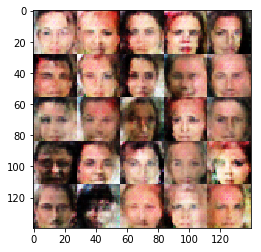

Epoch 1/1 - Batch 710/3165:  Discriminator loss = 0.5617  Generator loss = 0.4140
Epoch 1/1 - Batch 720/3165:  Discriminator loss = 0.5544  Generator loss = 0.2418
Epoch 1/1 - Batch 730/3165:  Discriminator loss = 0.5459  Generator loss = 0.3434
Epoch 1/1 - Batch 740/3165:  Discriminator loss = 0.5043  Generator loss = 0.4198
Epoch 1/1 - Batch 750/3165:  Discriminator loss = 0.5375  Generator loss = 0.4351
Epoch 1/1 - Batch 760/3165:  Discriminator loss = 0.5080  Generator loss = 0.3713
Epoch 1/1 - Batch 770/3165:  Discriminator loss = 0.4832  Generator loss = 0.4627
Epoch 1/1 - Batch 780/3165:  Discriminator loss = 0.5015  Generator loss = 0.2366
Epoch 1/1 - Batch 790/3165:  Discriminator loss = 0.4838  Generator loss = 0.4176
Epoch 1/1 - Batch 800/3165:  Discriminator loss = 0.4877  Generator loss = 0.4093


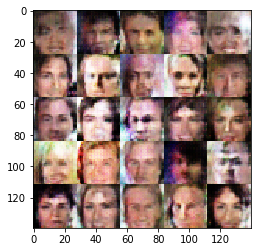

Epoch 1/1 - Batch 810/3165:  Discriminator loss = 0.5470  Generator loss = 0.4150
Epoch 1/1 - Batch 820/3165:  Discriminator loss = 0.5959  Generator loss = 0.3819
Epoch 1/1 - Batch 830/3165:  Discriminator loss = 0.4661  Generator loss = 0.2187
Epoch 1/1 - Batch 840/3165:  Discriminator loss = 0.4788  Generator loss = 0.2287
Epoch 1/1 - Batch 850/3165:  Discriminator loss = 0.5501  Generator loss = 0.4380
Epoch 1/1 - Batch 860/3165:  Discriminator loss = 0.5460  Generator loss = 0.4939
Epoch 1/1 - Batch 870/3165:  Discriminator loss = 0.4898  Generator loss = 0.4487
Epoch 1/1 - Batch 880/3165:  Discriminator loss = 0.5002  Generator loss = 0.3927
Epoch 1/1 - Batch 890/3165:  Discriminator loss = 0.4924  Generator loss = 0.3804
Epoch 1/1 - Batch 900/3165:  Discriminator loss = 0.5652  Generator loss = 0.2024


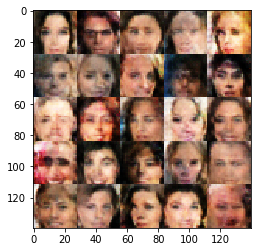

Epoch 1/1 - Batch 910/3165:  Discriminator loss = 0.5202  Generator loss = 0.4087
Epoch 1/1 - Batch 920/3165:  Discriminator loss = 0.4937  Generator loss = 0.4841
Epoch 1/1 - Batch 930/3165:  Discriminator loss = 0.5301  Generator loss = 0.2038
Epoch 1/1 - Batch 940/3165:  Discriminator loss = 0.5009  Generator loss = 0.3136
Epoch 1/1 - Batch 950/3165:  Discriminator loss = 0.5302  Generator loss = 0.1627
Epoch 1/1 - Batch 960/3165:  Discriminator loss = 0.5908  Generator loss = 0.3655
Epoch 1/1 - Batch 970/3165:  Discriminator loss = 0.4578  Generator loss = 0.4167
Epoch 1/1 - Batch 980/3165:  Discriminator loss = 0.5705  Generator loss = 0.4950
Epoch 1/1 - Batch 990/3165:  Discriminator loss = 0.5361  Generator loss = 0.1602
Epoch 1/1 - Batch 1000/3165:  Discriminator loss = 0.4914  Generator loss = 0.4015


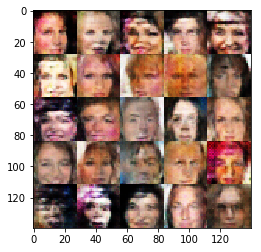

Epoch 1/1 - Batch 1010/3165:  Discriminator loss = 0.5215  Generator loss = 0.2283
Epoch 1/1 - Batch 1020/3165:  Discriminator loss = 0.4875  Generator loss = 0.2953
Epoch 1/1 - Batch 1030/3165:  Discriminator loss = 0.5836  Generator loss = 0.1768
Epoch 1/1 - Batch 1040/3165:  Discriminator loss = 0.4850  Generator loss = 0.3655
Epoch 1/1 - Batch 1050/3165:  Discriminator loss = 0.4370  Generator loss = 0.3914
Epoch 1/1 - Batch 1060/3165:  Discriminator loss = 0.4649  Generator loss = 0.3566
Epoch 1/1 - Batch 1070/3165:  Discriminator loss = 0.5446  Generator loss = 0.3216
Epoch 1/1 - Batch 1080/3165:  Discriminator loss = 0.4659  Generator loss = 0.1174
Epoch 1/1 - Batch 1090/3165:  Discriminator loss = 0.4776  Generator loss = 0.2990
Epoch 1/1 - Batch 1100/3165:  Discriminator loss = 0.5756  Generator loss = 0.1386


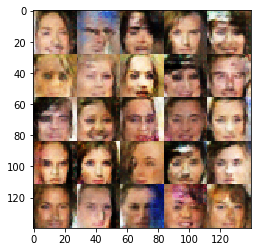

Epoch 1/1 - Batch 1110/3165:  Discriminator loss = 0.5938  Generator loss = 0.4403
Epoch 1/1 - Batch 1120/3165:  Discriminator loss = 0.5189  Generator loss = 0.3607
Epoch 1/1 - Batch 1130/3165:  Discriminator loss = 0.4681  Generator loss = 0.4913
Epoch 1/1 - Batch 1140/3165:  Discriminator loss = 0.4776  Generator loss = 0.1307
Epoch 1/1 - Batch 1150/3165:  Discriminator loss = 0.5948  Generator loss = 0.2610
Epoch 1/1 - Batch 1160/3165:  Discriminator loss = 0.5990  Generator loss = 0.4951
Epoch 1/1 - Batch 1170/3165:  Discriminator loss = 0.4624  Generator loss = 0.2858
Epoch 1/1 - Batch 1180/3165:  Discriminator loss = 0.5551  Generator loss = 0.2871
Epoch 1/1 - Batch 1190/3165:  Discriminator loss = 0.4523  Generator loss = 0.3133
Epoch 1/1 - Batch 1200/3165:  Discriminator loss = 0.4560  Generator loss = 0.2637


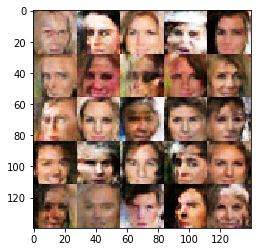

Epoch 1/1 - Batch 1210/3165:  Discriminator loss = 0.4618  Generator loss = 0.1787
Epoch 1/1 - Batch 1220/3165:  Discriminator loss = 0.5476  Generator loss = 0.2879
Epoch 1/1 - Batch 1230/3165:  Discriminator loss = 0.5967  Generator loss = 0.3073
Epoch 1/1 - Batch 1240/3165:  Discriminator loss = 0.5537  Generator loss = 0.1948
Epoch 1/1 - Batch 1250/3165:  Discriminator loss = 0.5135  Generator loss = 0.2723
Epoch 1/1 - Batch 1260/3165:  Discriminator loss = 0.5635  Generator loss = 0.3123
Epoch 1/1 - Batch 1270/3165:  Discriminator loss = 0.5143  Generator loss = 0.3238
Epoch 1/1 - Batch 1280/3165:  Discriminator loss = 0.4614  Generator loss = 0.1929
Epoch 1/1 - Batch 1290/3165:  Discriminator loss = 0.4626  Generator loss = 0.3421
Epoch 1/1 - Batch 1300/3165:  Discriminator loss = 0.5827  Generator loss = 0.4878


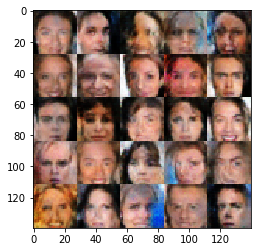

Epoch 1/1 - Batch 1310/3165:  Discriminator loss = 0.5676  Generator loss = 0.3183
Epoch 1/1 - Batch 1320/3165:  Discriminator loss = 0.4715  Generator loss = 0.4750
Epoch 1/1 - Batch 1330/3165:  Discriminator loss = 0.5735  Generator loss = 0.3976
Epoch 1/1 - Batch 1340/3165:  Discriminator loss = 0.5244  Generator loss = 0.3262
Epoch 1/1 - Batch 1350/3165:  Discriminator loss = 0.4611  Generator loss = 0.1850
Epoch 1/1 - Batch 1360/3165:  Discriminator loss = 0.5776  Generator loss = 0.2327
Epoch 1/1 - Batch 1370/3165:  Discriminator loss = 0.5670  Generator loss = 0.1115
Epoch 1/1 - Batch 1380/3165:  Discriminator loss = 0.5287  Generator loss = 0.4242
Epoch 1/1 - Batch 1390/3165:  Discriminator loss = 0.4553  Generator loss = 0.2315
Epoch 1/1 - Batch 1400/3165:  Discriminator loss = 0.5450  Generator loss = 0.1855


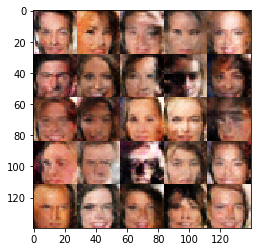

Epoch 1/1 - Batch 1410/3165:  Discriminator loss = 0.4616  Generator loss = 0.3965
Epoch 1/1 - Batch 1420/3165:  Discriminator loss = 0.5470  Generator loss = 0.1414
Epoch 1/1 - Batch 1430/3165:  Discriminator loss = 0.5719  Generator loss = 0.2462
Epoch 1/1 - Batch 1440/3165:  Discriminator loss = 0.5373  Generator loss = 0.3365
Epoch 1/1 - Batch 1450/3165:  Discriminator loss = 0.4747  Generator loss = 0.2656
Epoch 1/1 - Batch 1460/3165:  Discriminator loss = 0.5884  Generator loss = 0.4767
Epoch 1/1 - Batch 1470/3165:  Discriminator loss = 0.5430  Generator loss = 0.4206
Epoch 1/1 - Batch 1480/3165:  Discriminator loss = 0.5072  Generator loss = 0.4417
Epoch 1/1 - Batch 1490/3165:  Discriminator loss = 0.4040  Generator loss = 0.3049
Epoch 1/1 - Batch 1500/3165:  Discriminator loss = 0.5979  Generator loss = 0.4447


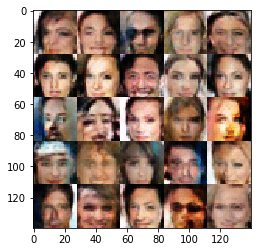

Epoch 1/1 - Batch 1510/3165:  Discriminator loss = 0.5770  Generator loss = 0.3845
Epoch 1/1 - Batch 1520/3165:  Discriminator loss = 0.5615  Generator loss = 0.4444
Epoch 1/1 - Batch 1530/3165:  Discriminator loss = 0.4597  Generator loss = 0.2371
Epoch 1/1 - Batch 1540/3165:  Discriminator loss = 0.5067  Generator loss = 0.4833
Epoch 1/1 - Batch 1550/3165:  Discriminator loss = 0.5352  Generator loss = 0.3003
Epoch 1/1 - Batch 1560/3165:  Discriminator loss = 0.5815  Generator loss = 0.4234
Epoch 1/1 - Batch 1570/3165:  Discriminator loss = 0.5760  Generator loss = 0.4448
Epoch 1/1 - Batch 1580/3165:  Discriminator loss = 0.5248  Generator loss = 0.1993
Epoch 1/1 - Batch 1590/3165:  Discriminator loss = 0.5588  Generator loss = 0.4639
Epoch 1/1 - Batch 1600/3165:  Discriminator loss = 0.5792  Generator loss = 0.1279


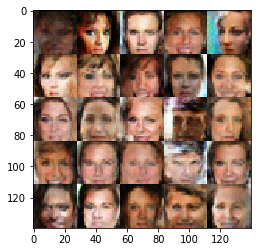

Epoch 1/1 - Batch 1610/3165:  Discriminator loss = 0.5492  Generator loss = 0.2502
Epoch 1/1 - Batch 1620/3165:  Discriminator loss = 0.5060  Generator loss = 0.3049
Epoch 1/1 - Batch 1630/3165:  Discriminator loss = 0.5434  Generator loss = 0.4760
Epoch 1/1 - Batch 1640/3165:  Discriminator loss = 0.5444  Generator loss = 0.3070
Epoch 1/1 - Batch 1650/3165:  Discriminator loss = 0.4235  Generator loss = 0.4682
Epoch 1/1 - Batch 1660/3165:  Discriminator loss = 0.4542  Generator loss = 0.4283
Epoch 1/1 - Batch 1670/3165:  Discriminator loss = 0.5472  Generator loss = 0.2649
Epoch 1/1 - Batch 1680/3165:  Discriminator loss = 0.4299  Generator loss = 0.3371
Epoch 1/1 - Batch 1690/3165:  Discriminator loss = 0.4462  Generator loss = 0.2648
Epoch 1/1 - Batch 1700/3165:  Discriminator loss = 0.5662  Generator loss = 0.1912


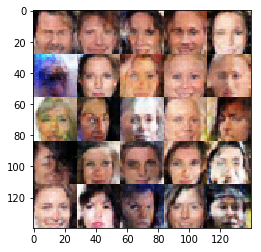

Epoch 1/1 - Batch 1710/3165:  Discriminator loss = 0.4257  Generator loss = 0.2623
Epoch 1/1 - Batch 1720/3165:  Discriminator loss = 0.5071  Generator loss = 0.2225
Epoch 1/1 - Batch 1730/3165:  Discriminator loss = 0.4998  Generator loss = 0.4955
Epoch 1/1 - Batch 1740/3165:  Discriminator loss = 0.5606  Generator loss = 0.2495
Epoch 1/1 - Batch 1750/3165:  Discriminator loss = 0.5573  Generator loss = 0.2351
Epoch 1/1 - Batch 1760/3165:  Discriminator loss = 0.5784  Generator loss = 0.1191
Epoch 1/1 - Batch 1770/3165:  Discriminator loss = 0.5641  Generator loss = 0.2196
Epoch 1/1 - Batch 1780/3165:  Discriminator loss = 0.5839  Generator loss = 0.4334
Epoch 1/1 - Batch 1790/3165:  Discriminator loss = 0.5857  Generator loss = 0.4193
Epoch 1/1 - Batch 1800/3165:  Discriminator loss = 0.5332  Generator loss = 0.1468


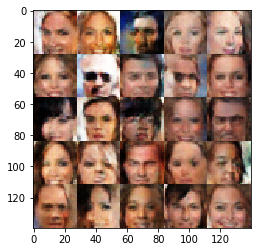

Epoch 1/1 - Batch 1810/3165:  Discriminator loss = 0.4553  Generator loss = 0.2177
Epoch 1/1 - Batch 1820/3165:  Discriminator loss = 0.5130  Generator loss = 0.4219
Epoch 1/1 - Batch 1830/3165:  Discriminator loss = 0.4955  Generator loss = 0.4044
Epoch 1/1 - Batch 1840/3165:  Discriminator loss = 0.5243  Generator loss = 0.2390
Epoch 1/1 - Batch 1850/3165:  Discriminator loss = 0.5627  Generator loss = 0.4708
Epoch 1/1 - Batch 1860/3165:  Discriminator loss = 0.5881  Generator loss = 0.3772
Epoch 1/1 - Batch 1870/3165:  Discriminator loss = 0.4889  Generator loss = 0.1856
Epoch 1/1 - Batch 1880/3165:  Discriminator loss = 0.5651  Generator loss = 0.2092
Epoch 1/1 - Batch 1890/3165:  Discriminator loss = 0.5654  Generator loss = 0.3885
Epoch 1/1 - Batch 1900/3165:  Discriminator loss = 0.5659  Generator loss = 0.0742


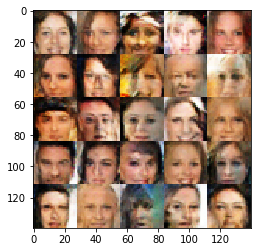

Epoch 1/1 - Batch 1910/3165:  Discriminator loss = 0.5208  Generator loss = 0.2277
Epoch 1/1 - Batch 1920/3165:  Discriminator loss = 0.5051  Generator loss = 0.3114
Epoch 1/1 - Batch 1930/3165:  Discriminator loss = 0.4882  Generator loss = 0.2135
Epoch 1/1 - Batch 1940/3165:  Discriminator loss = 0.4477  Generator loss = 0.2172
Epoch 1/1 - Batch 1950/3165:  Discriminator loss = 0.5551  Generator loss = 0.4314
Epoch 1/1 - Batch 1960/3165:  Discriminator loss = 0.4461  Generator loss = 0.2220
Epoch 1/1 - Batch 1970/3165:  Discriminator loss = 0.4983  Generator loss = 0.1916
Epoch 1/1 - Batch 1980/3165:  Discriminator loss = 0.5675  Generator loss = 0.4252
Epoch 1/1 - Batch 1990/3165:  Discriminator loss = 0.4070  Generator loss = 0.2290
Epoch 1/1 - Batch 2000/3165:  Discriminator loss = 0.5552  Generator loss = 0.4847


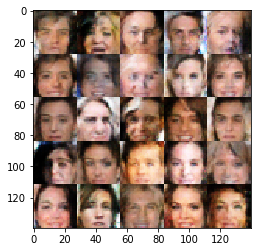

Epoch 1/1 - Batch 2010/3165:  Discriminator loss = 0.5625  Generator loss = 0.3377
Epoch 1/1 - Batch 2020/3165:  Discriminator loss = 0.5468  Generator loss = 0.2500
Epoch 1/1 - Batch 2030/3165:  Discriminator loss = 0.5490  Generator loss = 0.4964
Epoch 1/1 - Batch 2040/3165:  Discriminator loss = 0.5332  Generator loss = 0.2881
Epoch 1/1 - Batch 2050/3165:  Discriminator loss = 0.5009  Generator loss = 0.2945
Epoch 1/1 - Batch 2060/3165:  Discriminator loss = 0.5237  Generator loss = 0.3688
Epoch 1/1 - Batch 2070/3165:  Discriminator loss = 0.4820  Generator loss = 0.2798
Epoch 1/1 - Batch 2080/3165:  Discriminator loss = 0.4903  Generator loss = 0.1890
Epoch 1/1 - Batch 2090/3165:  Discriminator loss = 0.5633  Generator loss = 0.4724
Epoch 1/1 - Batch 2100/3165:  Discriminator loss = 0.4881  Generator loss = 0.2664


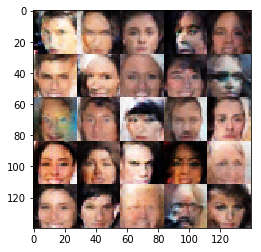

Epoch 1/1 - Batch 2110/3165:  Discriminator loss = 0.5190  Generator loss = 0.3908
Epoch 1/1 - Batch 2120/3165:  Discriminator loss = 0.5359  Generator loss = 0.2242
Epoch 1/1 - Batch 2130/3165:  Discriminator loss = 0.5606  Generator loss = 0.3877
Epoch 1/1 - Batch 2140/3165:  Discriminator loss = 0.5137  Generator loss = 0.3759
Epoch 1/1 - Batch 2150/3165:  Discriminator loss = 0.5566  Generator loss = 0.2519
Epoch 1/1 - Batch 2160/3165:  Discriminator loss = 0.4632  Generator loss = 0.2099
Epoch 1/1 - Batch 2170/3165:  Discriminator loss = 0.5006  Generator loss = 0.4171
Epoch 1/1 - Batch 2180/3165:  Discriminator loss = 0.5200  Generator loss = 0.3065
Epoch 1/1 - Batch 2190/3165:  Discriminator loss = 0.4354  Generator loss = 0.2647
Epoch 1/1 - Batch 2200/3165:  Discriminator loss = 0.4915  Generator loss = 0.3682


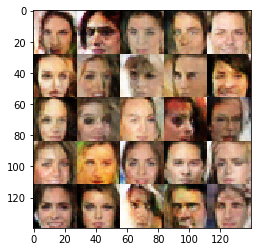

Epoch 1/1 - Batch 2210/3165:  Discriminator loss = 0.5620  Generator loss = 0.4185
Epoch 1/1 - Batch 2220/3165:  Discriminator loss = 0.4422  Generator loss = 0.2642
Epoch 1/1 - Batch 2230/3165:  Discriminator loss = 0.5310  Generator loss = 0.2865
Epoch 1/1 - Batch 2240/3165:  Discriminator loss = 0.4395  Generator loss = 0.3077
Epoch 1/1 - Batch 2250/3165:  Discriminator loss = 0.5018  Generator loss = 0.2148
Epoch 1/1 - Batch 2260/3165:  Discriminator loss = 0.4460  Generator loss = 0.4397
Epoch 1/1 - Batch 2270/3165:  Discriminator loss = 0.4809  Generator loss = 0.2928
Epoch 1/1 - Batch 2280/3165:  Discriminator loss = 0.4227  Generator loss = 0.3407
Epoch 1/1 - Batch 2290/3165:  Discriminator loss = 0.4888  Generator loss = 0.4420
Epoch 1/1 - Batch 2300/3165:  Discriminator loss = 0.4709  Generator loss = 0.2284


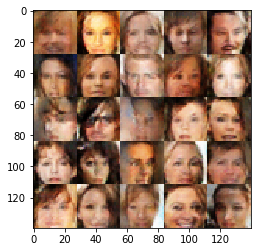

Epoch 1/1 - Batch 2310/3165:  Discriminator loss = 0.5272  Generator loss = 0.1952
Epoch 1/1 - Batch 2320/3165:  Discriminator loss = 0.5114  Generator loss = 0.2325
Epoch 1/1 - Batch 2330/3165:  Discriminator loss = 0.5223  Generator loss = 0.2349
Epoch 1/1 - Batch 2340/3165:  Discriminator loss = 0.4160  Generator loss = 0.2660
Epoch 1/1 - Batch 2350/3165:  Discriminator loss = 0.4918  Generator loss = 0.2702
Epoch 1/1 - Batch 2360/3165:  Discriminator loss = 0.5586  Generator loss = 0.2775
Epoch 1/1 - Batch 2370/3165:  Discriminator loss = 0.5439  Generator loss = 0.2042
Epoch 1/1 - Batch 2380/3165:  Discriminator loss = 0.4627  Generator loss = 0.2582
Epoch 1/1 - Batch 2390/3165:  Discriminator loss = 0.5266  Generator loss = 0.3758
Epoch 1/1 - Batch 2400/3165:  Discriminator loss = 0.5051  Generator loss = 0.2801


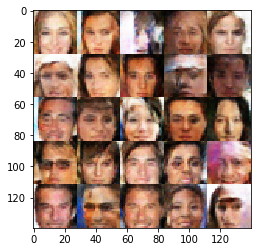

Epoch 1/1 - Batch 2410/3165:  Discriminator loss = 0.4981  Generator loss = 0.1630
Epoch 1/1 - Batch 2420/3165:  Discriminator loss = 0.5095  Generator loss = 0.2570
Epoch 1/1 - Batch 2430/3165:  Discriminator loss = 0.4805  Generator loss = 0.4517
Epoch 1/1 - Batch 2440/3165:  Discriminator loss = 0.5285  Generator loss = 0.3249
Epoch 1/1 - Batch 2450/3165:  Discriminator loss = 0.5223  Generator loss = 0.3199
Epoch 1/1 - Batch 2460/3165:  Discriminator loss = 0.5663  Generator loss = 0.4015
Epoch 1/1 - Batch 2470/3165:  Discriminator loss = 0.5310  Generator loss = 0.3026
Epoch 1/1 - Batch 2480/3165:  Discriminator loss = 0.5943  Generator loss = 0.4052
Epoch 1/1 - Batch 2490/3165:  Discriminator loss = 0.5801  Generator loss = 0.1988
Epoch 1/1 - Batch 2500/3165:  Discriminator loss = 0.4660  Generator loss = 0.2029


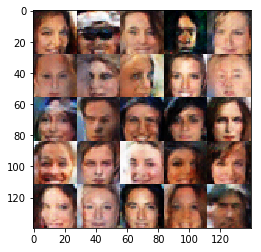

Epoch 1/1 - Batch 2510/3165:  Discriminator loss = 0.4880  Generator loss = 0.4873
Epoch 1/1 - Batch 2520/3165:  Discriminator loss = 0.4131  Generator loss = 0.3786
Epoch 1/1 - Batch 2530/3165:  Discriminator loss = 0.5161  Generator loss = 0.3575
Epoch 1/1 - Batch 2540/3165:  Discriminator loss = 0.4327  Generator loss = 0.2624
Epoch 1/1 - Batch 2550/3165:  Discriminator loss = 0.4211  Generator loss = 0.3287
Epoch 1/1 - Batch 2560/3165:  Discriminator loss = 0.4374  Generator loss = 0.1202
Epoch 1/1 - Batch 2570/3165:  Discriminator loss = 0.4525  Generator loss = 0.2458
Epoch 1/1 - Batch 2580/3165:  Discriminator loss = 0.4269  Generator loss = 0.2098
Epoch 1/1 - Batch 2590/3165:  Discriminator loss = 0.5824  Generator loss = 0.3595
Epoch 1/1 - Batch 2600/3165:  Discriminator loss = 0.4653  Generator loss = 0.3304


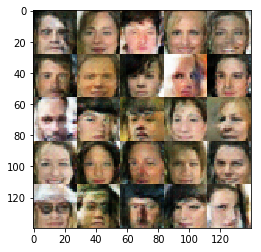

Epoch 1/1 - Batch 2610/3165:  Discriminator loss = 0.5039  Generator loss = 0.4029
Epoch 1/1 - Batch 2620/3165:  Discriminator loss = 0.5827  Generator loss = 0.3559
Epoch 1/1 - Batch 2630/3165:  Discriminator loss = 0.5386  Generator loss = 0.2654
Epoch 1/1 - Batch 2640/3165:  Discriminator loss = 0.4496  Generator loss = 0.4280
Epoch 1/1 - Batch 2650/3165:  Discriminator loss = 0.5661  Generator loss = 0.3471
Epoch 1/1 - Batch 2660/3165:  Discriminator loss = 0.4811  Generator loss = 0.2676
Epoch 1/1 - Batch 2670/3165:  Discriminator loss = 0.4544  Generator loss = 0.2485
Epoch 1/1 - Batch 2680/3165:  Discriminator loss = 0.5450  Generator loss = 0.3576
Epoch 1/1 - Batch 2690/3165:  Discriminator loss = 0.5724  Generator loss = 0.2918
Epoch 1/1 - Batch 2700/3165:  Discriminator loss = 0.5101  Generator loss = 0.3906


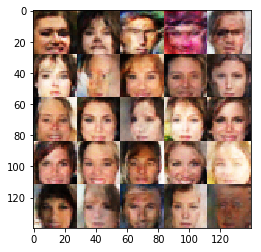

Epoch 1/1 - Batch 2710/3165:  Discriminator loss = 0.5536  Generator loss = 0.3170
Epoch 1/1 - Batch 2720/3165:  Discriminator loss = 0.4639  Generator loss = 0.3376
Epoch 1/1 - Batch 2730/3165:  Discriminator loss = 0.4558  Generator loss = 0.2543
Epoch 1/1 - Batch 2740/3165:  Discriminator loss = 0.5201  Generator loss = 0.2510
Epoch 1/1 - Batch 2750/3165:  Discriminator loss = 0.5031  Generator loss = 0.3460
Epoch 1/1 - Batch 2760/3165:  Discriminator loss = 0.4937  Generator loss = 0.2203
Epoch 1/1 - Batch 2770/3165:  Discriminator loss = 0.4184  Generator loss = 0.4559
Epoch 1/1 - Batch 2780/3165:  Discriminator loss = 0.4518  Generator loss = 0.2637
Epoch 1/1 - Batch 2790/3165:  Discriminator loss = 0.5505  Generator loss = 0.3784
Epoch 1/1 - Batch 2800/3165:  Discriminator loss = 0.5191  Generator loss = 0.4066


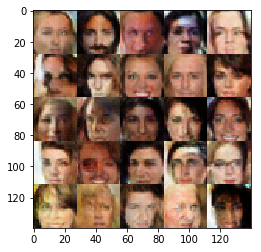

Epoch 1/1 - Batch 2810/3165:  Discriminator loss = 0.5034  Generator loss = 0.3623


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.